## Gesture Recognition

In [1]:
#Checking GPU active status
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install ipython-autotime
%load_ext autotime

time: 146 µs


In [4]:
import numpy as np
import os
import skimage
from skimage.transform import resize
import datetime
import os
import cv2
import random as rn
from keras import backend as K
import matplotlib.pyplot as plt
% matplotlib inline

time: 1.27 s


In [5]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

time: 1.55 ms


In [27]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

time: 4.45 ms


In [49]:
# Reading training and validation folder names
train_doc = np.random.permutation(open('/content/gdrive/My Drive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/My Drive/Project_data/val.csv').readlines())

time: 8.72 ms


In [50]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img,rows,cols):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = skimage.transform.resize(img, (rows,cols,3))
    return resized_image

time: 3.02 ms


In [52]:
# Preprocessing the images before feed data to the model in batches.

def fetch_aug_batchdata(source_path, folder_list, batch_num, batch_size, t,validation,frames_to_sample,h,w):
    
    # intialize variables to store data read from train data
    batch_data = np.zeros((batch_size,30,w,h,3)) # batch_size is the number of images you use for each video, (w,h) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    #print(batch_data)
    #print(batch_labels)
    # intialize variables for augumented batch data with affine transformation
    batch_data_aug,batch_label_aug = batch_data,batch_labels
    #print(batch_data_aug)
    #print(batch_label_aug)
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = np.round(np.linspace(0,29,frames_to_sample)).astype(int)
    
    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # create a random affine to be used in image transformation for buidling agumented data set
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        
        #  Iterate over the frames for each folder to read them in
        for idx, item in enumerate(img_idx):             
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)           
            # Cropping non symmetric frames
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes 
            resized_image=crop_resize_img(image,w,h)
            
            #normalizing the images
            batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255
            
            x =resized_image.shape[0]
            y =resized_image.shape[1]
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized_image, M, (x,y)))
            

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_label_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
                  
    #adding the augumented data in the main data.
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)

    batch_label_final = np.append(batch_labels, batch_label_aug, axis = 0) 
    
    if validation:
        batch_data_final=batch_data
        batch_label_final= batch_labels
        
    return batch_data_final,batch_label_final

time: 63.5 ms


In [54]:
# Generator Function

def generator(source_path, folder_list, batch_size, frame_diff,h,w,validation=False,ablation=None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    if(ablation!=None):
        folder_list=folder_list[:ablation]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield fetch_aug_batchdata(source_path, folder_list, batch, batch_size, t,validation,frame_diff,h,w)
            
        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield fetch_aug_batchdata(source_path, folder_list, batch, batch_size, t,validation,frame_diff,h,w)

time: 6.15 ms


In [55]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Project_data/train'
val_path = '/content/gdrive/My Drive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100
time: 2.02 ms


In [56]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam

time: 2.9 ms


In [57]:
def train_model(batch_size,frame_diff,h,w,num_epochs):
        model = model1(w,h)
        train_generator = generator(train_path, train_doc, batch_size,frame_diff,h,w)
        val_generator = generator(val_path, val_doc, batch_size,frame_diff,h,w,validation=True)

        model_name = '/content/gdrive/My Drive/Project_data/model_5' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

time: 29.5 ms


# Using Convolution 3D Architecture

In [45]:
# model
def model1(rows,cols):
  nb_dense = [256,128,64,5]
  nb_classes = 5
  filtersize=(3,3,3)
  dropout=0.3
  frames=30
  # Input
  input_shape=(frames,rows,cols,3)

  model = Sequential()
  model.add(Conv3D(16, filtersize, padding='same',
            input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(32, filtersize, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(64, filtersize, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(128, filtersize, padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Flatten())
  model.add(Dense(nb_dense[0],activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(nb_dense[1],activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))


  model.add(Dense(nb_classes,activation='softmax'))

  optimiser = optimizers.Adam(lr=0.0001)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print(model.summary())
  return model

time: 27.3 ms


In [46]:
# argument list - batch_size,frames_to_sample,h,w,num_epochs
history_model = train_model(25,20,140,140,30)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 140, 140, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 140, 140, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 140, 140, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 70, 70, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 70, 70, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 15, 70, 70, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 70, 70, 32)   

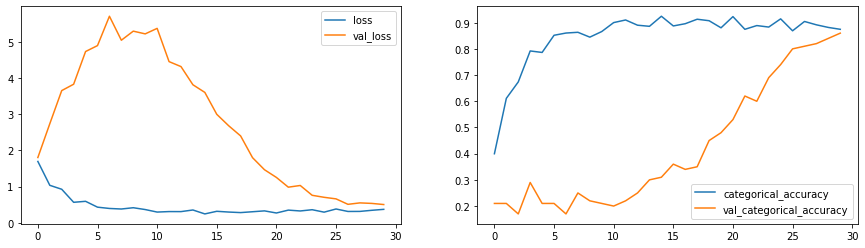

time: 370 ms


In [47]:
plot(history_model)

### This model doesnt overfits and also gives good accuracy of around 86%.
### So we will choose this as our final model